# Position Classification for FC Barcelona's Youth Players
### Team Sarria: Maëlys Boudier, Viktoriia Yuzkiv, Miguel Handt

**Course**: Computational Machine Learning taught by Anna Corretger

Objective: Predict player's position given a set of characteristics

Overview:
1. Data Preprocessing & Quality Assurance
1. Feature Creation and Engineering
1. Exploratory Data Analysis
1. Cross-Validation Strategy
1. Model Selection and Justification
1. Ensemble Modeling (Bonus Objective)
1. Performance Evaluation - accuracy, precision, recall, f1
1. Get Predictions for Kaggle Competition 

## 0. Set-Up

### Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings 

# Libraries for Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# libraries for Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

warnings.filterwarnings("ignore")

In [2]:
# Set global plots style
plt.style.use('ggplot')

In [3]:
# Set Preferences for Displaying Pandas Dataframes
pd.options.display.max_rows = 100
pd.options.display.max_columns = 30

### Load Data

In [4]:
# Define file path
file_path_train = os.getcwd()+'/train.csv'
file_path_test = os.getcwd()+'/test.csv'

# Load train and test data
train_raw = pd.read_csv(file_path_train)
test_raw = pd.read_csv(file_path_test)

In [5]:
print(f'The train dataset has {train_raw.shape[0]} rows and {train_raw.shape[1]} columns.') 

The train dataset has 6895 rows and 70 columns.


In [6]:
print(f'The test dataset has {test_raw.shape[0]} rows and {test_raw.shape[1]} columns.') 

The test dataset has 767 rows and 69 columns.


In [7]:
# Concatenate train and test data
df_raw = pd.concat([train_raw, test_raw], ignore_index=True)

# 1. Exploratory Data Analysis

In [8]:
# Display basic information about the dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           7662 non-null   int64  
 1   short_name                   7662 non-null   object 
 2   overall                      7662 non-null   int64  
 3   potential                    7662 non-null   int64  
 4   value_eur                    7657 non-null   float64
 5   wage_eur                     7662 non-null   int64  
 6   birthday_date                7662 non-null   object 
 7   height_cm                    7662 non-null   int64  
 8   weight_kg                    7662 non-null   int64  
 9   club_name                    7662 non-null   object 
 10  league_name                  7662 non-null   object 
 11  league_level                 7662 non-null   int64  
 12  club_jersey_number           7662 non-null   int64  
 13  club_loaned_from  

### Check for Missing Values

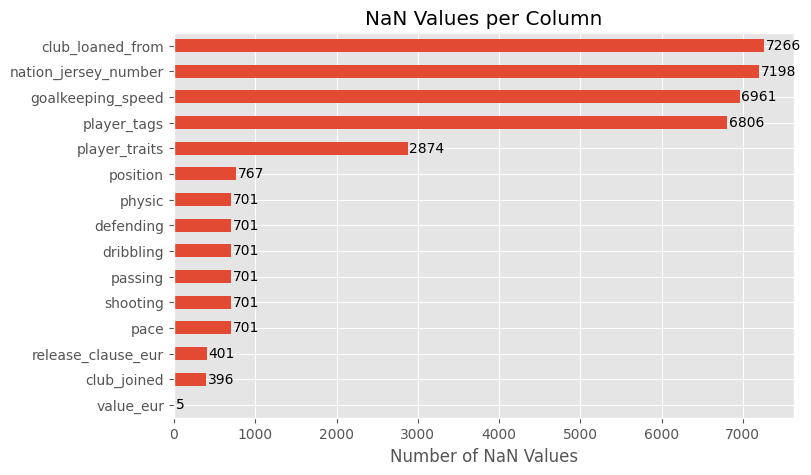

In [9]:
# Check for NaN values and filter columns with more than 0 NaN
na_counts = df_raw.isna().sum()
columns_with_nan = na_counts[na_counts > 0].index
df_missing = na_counts[columns_with_nan].sort_values(ascending=True)

ax = df_missing.plot(kind='barh', figsize=(8, 5))
plt.title('NaN Values per Column')
plt.xlabel('Number of NaN Values')

# Add numbers on the right side of each bar
for i, v in enumerate(df_missing):
    ax.text(v + 20, i, str(v), ha='left', va='center')

plt.show()

Columns that miss more than 80% of the data:
- club_loaned_from
- nation_jersey_number
- goalkeeping_speed
- player_tags

As the goalkeeping_speed most likely is related to the goal keeper characteristics only, it needs more investigation to check if it is populated only for goal keepers or if it also has missing data.

Columns club_loaned_from, nation_jersey_number, player_tags will be dropped in the Data Preparation part due to the high missing values number.

In [10]:
# Checking if goalkeeping_speed is imputed only for position == GK (in the train data only as the test data doesn't have the position column)

res = train_raw[train_raw['position'] == 'GK']['goalkeeping_speed'].notnull().all()
print(f'All values for GK are imputed: {res}')

res1 = train_raw[train_raw['position'] != 'GK']['goalkeeping_speed'].isnull().all()
print(f'No values of goalkeeping_speed for all the other positons are imputed: {res1}')

All values for GK are imputed: True
No values of goalkeeping_speed for all the other positons are imputed: True


Therefore, we see that goalkeeping_speed is imputed only for the position of GK, for all the other positions it's NaN. 

In [11]:
na_counts_GK = df_raw[df_raw['position'] == 'GK'].isna().sum().sort_values(ascending=True)
print('Missing values for the GK position: \n')
print(na_counts_GK[na_counts_GK > 0])

Missing values for the GK position: 

release_clause_eur       33
club_joined              33
player_traits           251
nation_jersey_number    571
club_loaned_from        598
pace                    631
shooting                631
passing                 631
dribbling               631
defending               631
player_tags             631
physic                  631
dtype: int64


Also we see that for the GK position such columns as pace, shooting, passing, dribbling, defending, player_tags, physic are completely missing, so we assume that those are not relevant for GK.

### Numerical Variables Exploration

In [12]:
# Summary statistics for numerical columns
df_raw.describe()

,id,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,7662.000000,7662.000000,7662.000000,7.657000e+03,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,464.000000,7662.000000,7662.000000,7662.000000,7.261000e+03,...,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,701.000000
mean,223616.285435,68.842600,72.048029,4.331453e+06,12030.253198,181.484338,75.552467,1.361655,16.525320,2022.763508,12.056034,2.996346,2.451188,1.147481,8.187938e+06,...,59.815714,51.504960,53.130645,56.939441,49.895589,61.901592,51.349517,52.304098,49.800052,15.903289,15.672409,15.545680,15.813234,16.011877,40.375178
std,26710.529813,5.951663,6.074939,1.045019e+07,24385.866372,6.860952,7.042419,0.761018,15.487419,1.207030,6.902991,0.685301,0.780693,0.470143,2.044656e+07,...,16.272640,20.123523,19.313219,13.559154,15.668827,10.886174,19.658360,20.918691,20.638862,17.466642,16.767293,16.319634,17.191808,17.877237,10.194699
min,41.000000,48.000000,53.000000,2.500000e+04,500.000000,156.000000,53.000000,1.000000,1.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,3.900000e+04,...,11.000000,6.000000,2.000000,10.000000,8.000000,12.000000,4.000000,5.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000
25%,207642.250000,65.000000,68.000000,7.250000e+05,2000.000000,177.000000,70.000000,1.000000,6.000000,2022.000000,6.000000,3.000000,2.000000,1.000000,1.100000e+06,...,51.000000,33.000000,42.000000,48.000000,40.000000,56.000000,35.000000,34.000000,31.000000,8.000000,8.000000,8.000000,8.000000,8.000000,33.000000
50%,228152.500000,68.000000,72.000000,1.400000e+06,4000.000000,182.000000,75.000000,1.000000,13.000000,2023.000000,12.000000,3.000000,2.000000,1.000000,2.300000e+06,...,63.000000,59.000000,59.000000,59.000000,50.000000,63.000000,58.000000,61.000000,58.000000,11.000000,11.000000,11.000000,11.000000,11.000000,42.000000
75%,242513.500000,72.000000,76.000000,3.000000e+06,12000.000000,186.000000,80.000000,1.000000,22.000000,2024.000000,18.000000,3.000000,3.000000,1.000000,5.400000e+06,...,72.000000,67.000000,67.000000,67.000000,62.000000,69.000000,66.000000,68.000000,66.000000,14.000000,14.000000,14.000000,14.000000,14.000000,47.000000
max,264481.000000,93.000000,95.000000,1.940000e+08,350000.000000,203.000000,103.000000,5.000000,99.000000,2031.000000,28.000000,5.000000,5.000000,5.000000,3.735000e+08,...,95.000000,91.000000,96.000000,95.000000,93.000000,96.000000,92.000000,93.000000,92.000000,91.000000,92.000000,93.000000,92.000000,90.000000,65.000000


Columns value_eur and wage_eur have high standard deviations, suggesting the presence of extreme values (potential outliers). It will be explored more in the further analysis.

Columns height_cm and weight_kg have moderate standard deviations, indicating some variability in player physical attributes. The relationships between player posisions and the phisical attributes will be studied later as well.

All the other columns have relatively law standard deviations and are not a cause for concern.

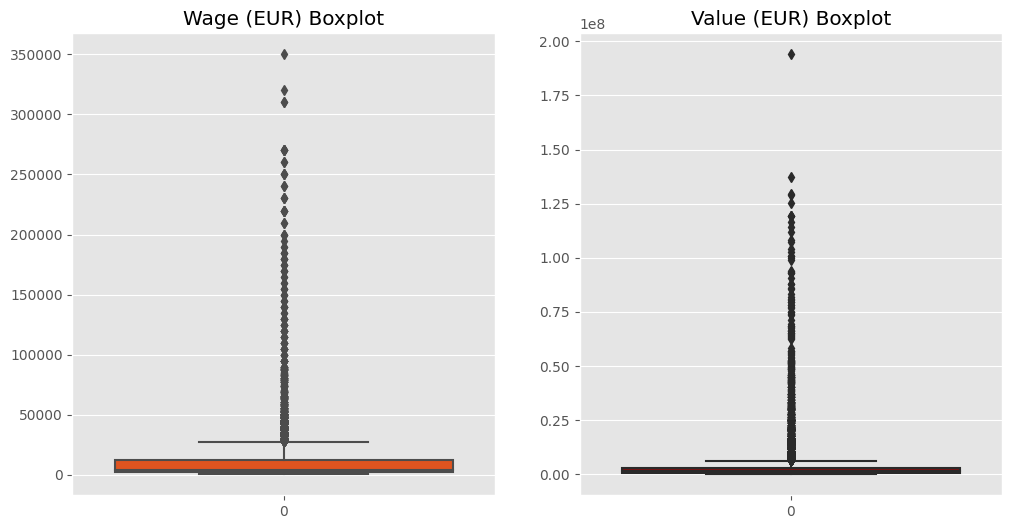

In [13]:
# Check value_eur and wage_eur columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(df_raw['wage_eur'], ax=axes[0], color='orangered')
axes[0].set_title('Wage (EUR) Boxplot')

sns.boxplot(df_raw['value_eur'], ax=axes[1], color='darkred')
axes[1].set_title('Value (EUR) Boxplot')

plt.show()

As we can see in the boxplots above, both height_cm and weight_kg variables have outliers. We will remove those in the data preparation part.

Let's take a look at the distributions of both columns:

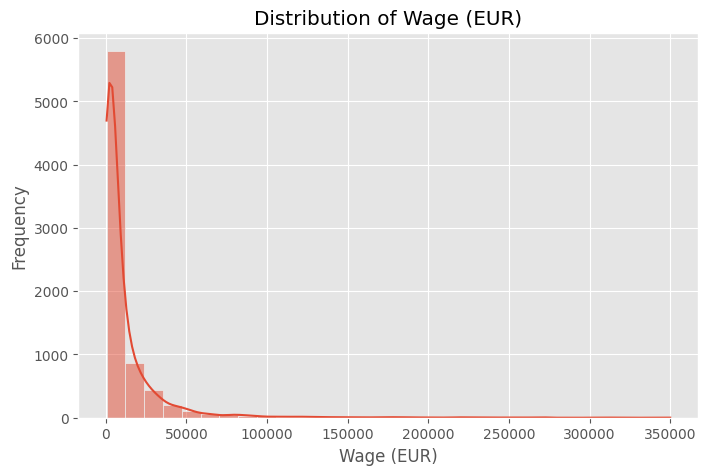

In [14]:
# Visualize the distribution of the wage_eur variable

plt.figure(figsize=(8, 5))
sns.histplot(df_raw['wage_eur'], bins=30, kde=True)
plt.title('Distribution of Wage (EUR)')
plt.xlabel('Wage (EUR)')
plt.ylabel('Frequency')
plt.show()

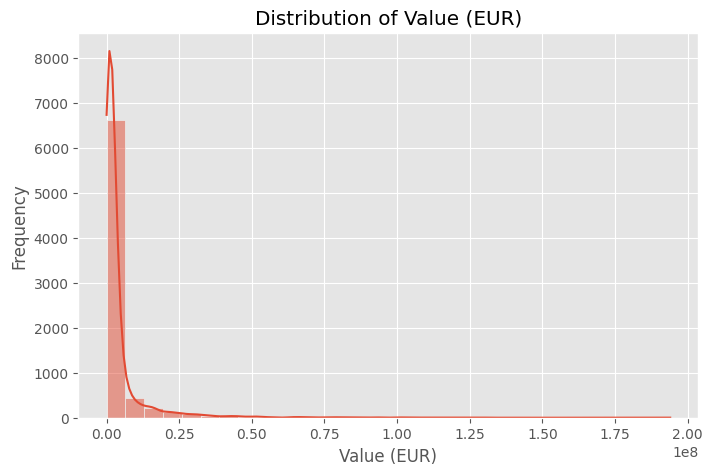

In [15]:
# Visualize the distribution of the value_eur variable

plt.figure(figsize=(8, 5))
sns.histplot(df_raw['value_eur'], bins=30, kde=True)
plt.title('Distribution of Value (EUR)')
plt.xlabel('Value (EUR)')
plt.ylabel('Frequency')
plt.show()

Both height_cm and weight_kg are highly right skewed. The distributions should be checked again after the outliers are removed.

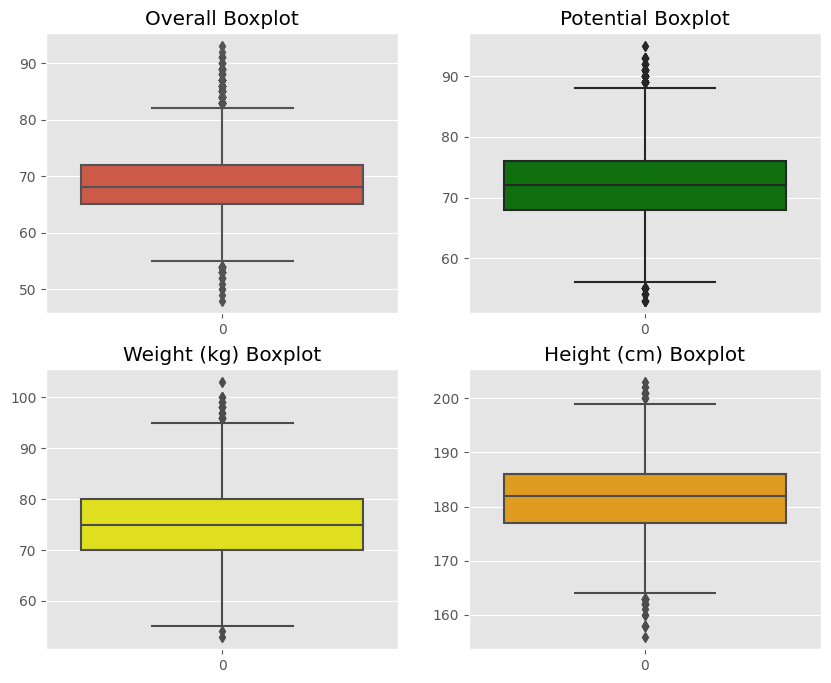

In [16]:
# Check other main numerical columns

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.boxplot(df_raw['overall'], ax = axes[0,0])
axes[0,0].set_title('Overall Boxplot')

sns.boxplot(df_raw['potential'], ax = axes[0,1], color='green')
axes[0,1].set_title('Potential Boxplot')

sns.boxplot(df_raw['weight_kg'], ax = axes[1,0], color = 'yellow')
axes[1,0].set_title('Weight (kg) Boxplot')

sns.boxplot(df_raw['height_cm'], ax = axes[1,1], color='orange')
axes[1,1].set_title('Height (cm) Boxplot')

plt.show()

There might be some outliers in the overall, potential, weight_kg, height_cm columns, too. We will check later if it's needed to remove them from the data.


Let's take a look at correlations between the numerical variables.

In [17]:
# Correlation heatmap

cols = ['overall', 'potential', 'value_eur', 'release_clause_eur', 'wage_eur', 'weak_foot', 'international_reputation',
    'height_cm', 'weight_kg','skill_moves', 'pace', 'shooting', 'passing', 'dribbling',
    'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
    'attacking_heading_accuracy', 'attacking_short_passing',
    'attacking_volleys', 'skill_dribbling', 'skill_curve',
    'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
    'movement_reactions', 'movement_balance', 'power_shot_power',
    'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
    'mentality_aggression', 'mentality_interceptions',
    'mentality_positioning', 'mentality_vision', 'mentality_penalties',
    'mentality_composure', 'defending_marking_awareness',
    'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving',
    'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
    'goalkeeping_reflexes', 'goalkeeping_speed']

correlation_matrix = df_raw[cols].corr()
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Insights from the correlation matrix:
- all goalkeeping variables (except for goalkeeping_speed) are highly positively correlated with each other.
- goalkeeping_speed is highly correlated to movement_acceleration ans movement_sprint_speed.
- defending_marking_awareness, defending_standing_tackle, defending_sliding_tackle are higly positively correlated with each other, and also there is a high correlation to variables defending, mentality_interceptions.
- power_long_shots and attacking_finishing are highly positively correlated with shooting.
- movement_balance is highly negatively correlated with height_cm.
- movement_acceleration and movement_sprint_speed are highly positively correlated with the pace variable
- both skill_ball_control and skill_dribbling are highly positively correlated with defending and attacking_short_passing.
- release_clause_eur is perfectly correlated to value_err. As release_clause_eur has some missing values, it can be either droppped because of high correlecation with value_err or imputed using value_err -> we will decide later.

We will select the variables we want to keep/drop based on the correlations in the data preparation part.

### Categorical Variables Exploration

In [ ]:
# # Summary table for categorical variables

# def categorical_summary(df):
#     # Initialize an empty DataFrame to store the results
#     cat_summary_df = pd.DataFrame(columns=['Variable', 'Data Type', 'Unique Values', 'Missing Values (%)', 'Top Values'])
    
#     # Iterate over all columns and fill the summary DataFrame for categorical columns
#     for column in df.columns:
#         if df[column].dtype == 'O':
#             unique_values = df[column].nunique()
#             missing_percentage = (df[column].isnull().mean()) * 100
#             top_values = df[column].value_counts().head().index.tolist()

#             # Add a new row to the summary DataFrame
#             cat_summary_df = cat_summary_df.append({
#                 'Variable': column,
#                 'Data Type': df[column].dtype,
#                 'Unique Values': unique_values,
#                 'Missing Values (%)': missing_percentage,
#                 'Top Values': top_values
#             }, ignore_index=True)
    
#     return cat_summary_df

# # Example usage:
# # Assuming your DataFrame is named 'your_dataframe'
# summary_df = categorical_summary(df_raw)
# display(summary_df)


As the position of the player does not depend on the birthday date, it is possible that there is relationship between the age of the player (or year born) and the position.

In [ ]:
# Convert 'birthday_date' to datetime format
df_raw['birthday_date'] = pd.to_datetime(df_raw['birthday_date'])

# Extract the year and create a new column 'year_born'
df_raw['year_born'] = df_raw['birthday_date'].dt.year

The variable body_type might be the combination of height_cm and weight_cm. Let's take a look at the chart to see if this hypothesis is true. If yes, we can remove the body_type column from our dataset.

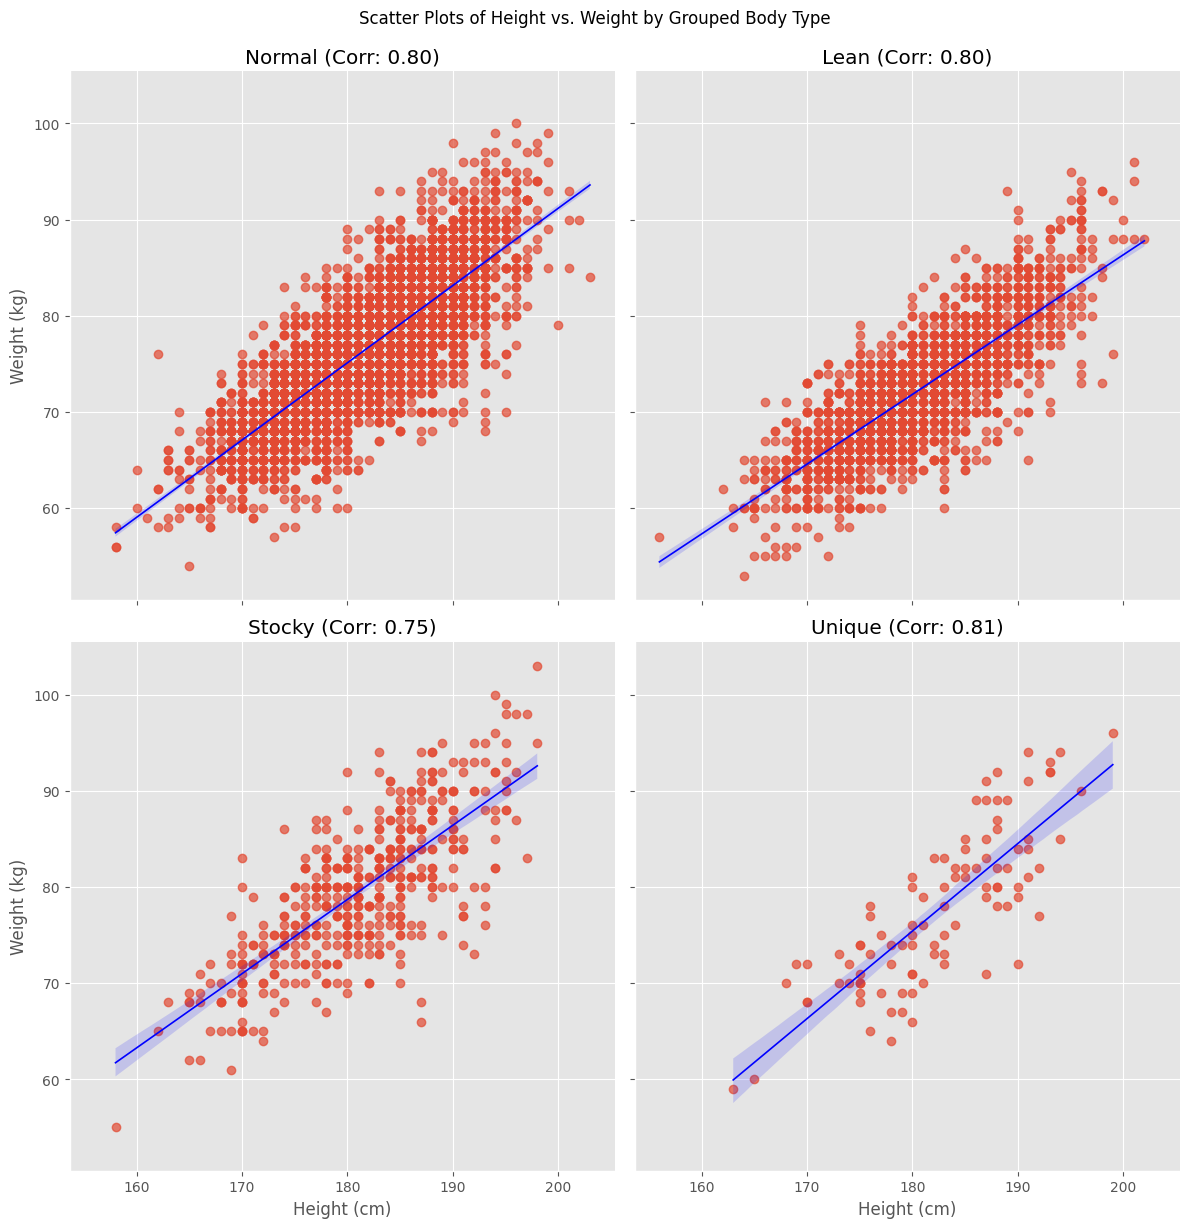

In [ ]:
# Create a new column 'body_type_grouped' based on the existing 'body_type' values
df_raw['body_type_grouped'] = df_raw['body_type'].apply(lambda x: 'Normal' if 'Normal' in x else ('Lean' if 'Lean' in x else ('Stocky' if 'Stocky' in x else 'Unique')))

# Create a FacetGrid with separate subplots for each grouped body type
g = sns.FacetGrid(df_raw, col='body_type_grouped', col_wrap=2, height=6)
g.map(sns.regplot, 'height_cm', 'weight_kg', scatter_kws={'alpha': 0.7}, line_kws={'color': 'blue', 'linewidth': 1.2})  # Use the alpha parameter to control point transparency
g.set_axis_labels('Height (cm)', 'Weight (kg)')

# Add a title with correlation score to each subplot
for ax in g.axes.flat:
    body_type = ax.get_title().split('=')[-1].strip()
    subset = df_raw[df_raw['body_type_grouped'] == body_type]
    correlation = subset[['height_cm', 'weight_kg']].corr().iloc[0, 1]
    ax.set_title(f'{body_type} (Corr: {correlation:.2f})')

g.fig.suptitle('Scatter Plots of Height vs. Weight by Grouped Body Type', y=1.02)
plt.show()

For all body types we see that there is a strong linear relationship between weight_cm and height_cm.

#### Explore the 'Position' Column

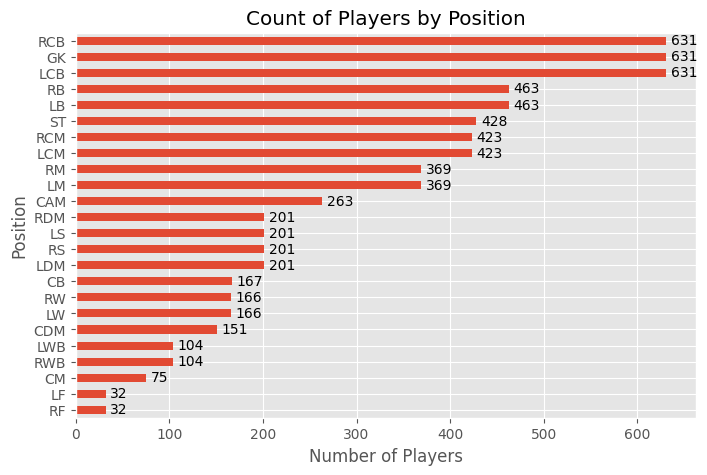

In [ ]:
# Number of players by position
position_count = df_raw['position'].value_counts().sort_values(ascending=True)

ax = position_count.plot(kind='barh', figsize=(8, 5))
plt.title('Count of Players by Position')
plt.xlabel('Number of Players')
plt.ylabel('Position')

# Add numbers on the right side of each bar
for i, v in enumerate(position_count):
    ax.text(v + 5, i, str(v), ha='left', va='center')

plt.show()

Let's check if the main player characteristics differ between positions.

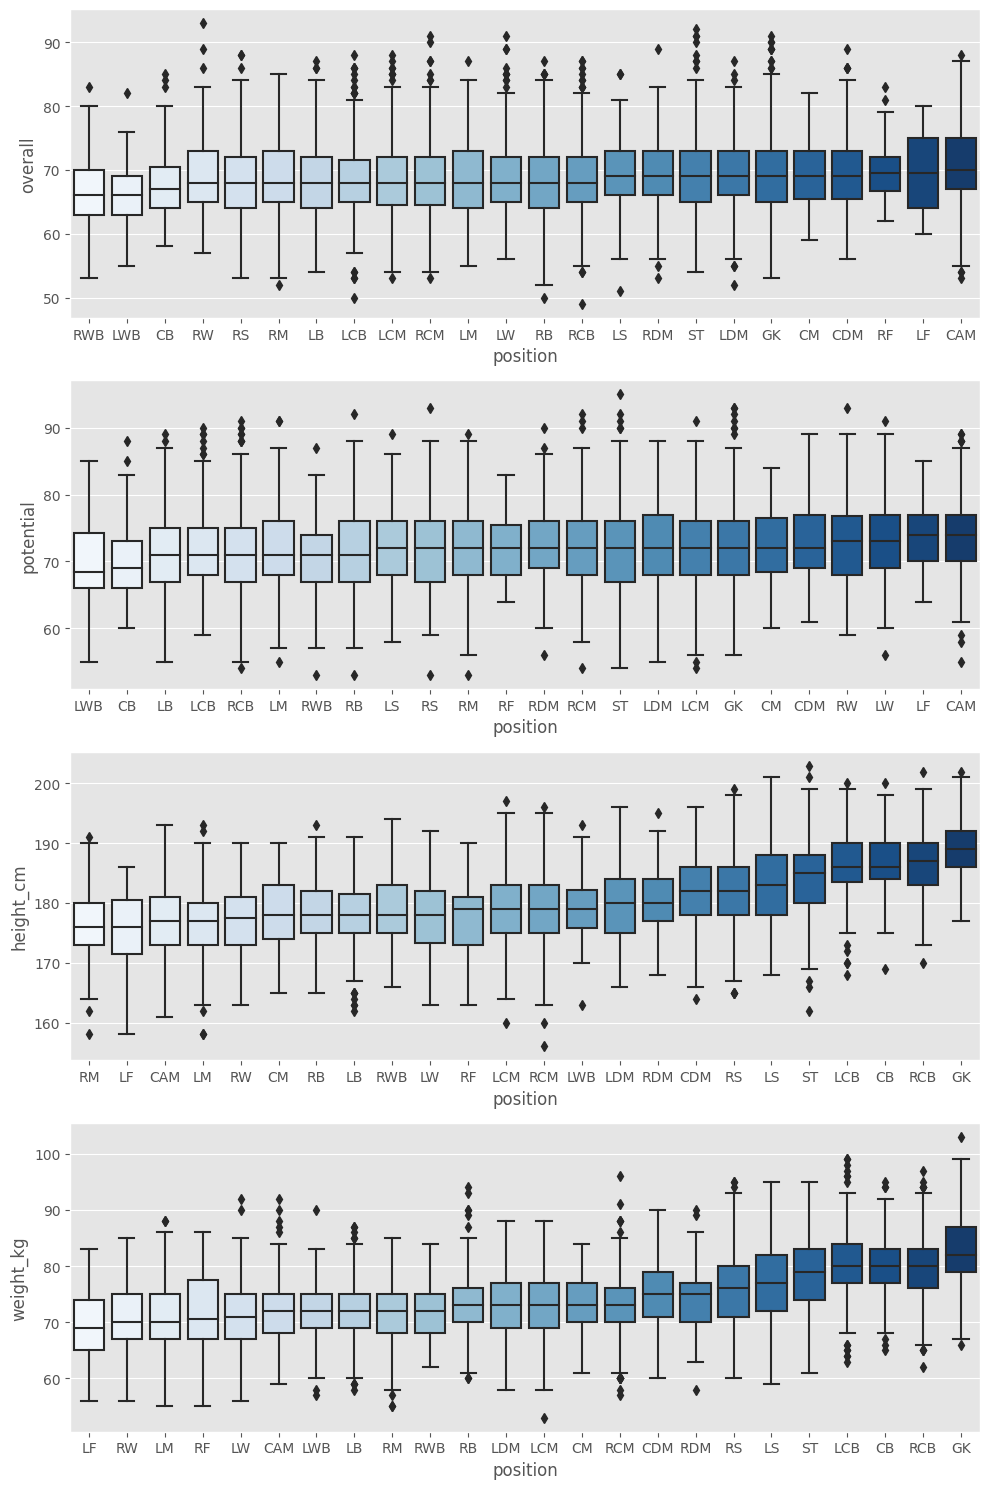

In [ ]:
# Calculate the median overall for each position
median_overall = df_raw.groupby('position')['overall'].median().sort_values(ascending=True)

# Calculate the meadian potential for each position
median_potential = df_raw.groupby('position')['potential'].median().sort_values(ascending=True)

# Calculate the meadian height for each position
median_heights = df_raw.groupby('position')['height_cm'].median().sort_values(ascending=True)

# Calculate the meadian weight for each position
median_weights = df_raw.groupby('position')['weight_kg'].median().sort_values(ascending=True)

# Create a subplot with two axes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# Plot the boxplot for overall on the first axis
sns.boxplot(ax=axes[0], x='position', y='overall', data=df_raw, palette='Blues', order=median_overall.index)

# Plot the boxplot for potential on the second axis
sns.boxplot(ax=axes[1], x='position', y='potential', data=df_raw, palette='Blues', order=median_potential.index)

# Plot the boxplot for height on the third axis
sns.boxplot(ax=axes[2], x='position', y='height_cm', data=df_raw, palette='Blues', order=median_heights.index)

# Plot the boxplot for weight on the fourth axis
sns.boxplot(ax=axes[3], x='position', y='weight_kg', data=df_raw, palette='Blues', order=median_weights.index)

# Adjust layout
plt.tight_layout()
plt.show()

While for overall and potential columns the difference is quite small among different positions, players height and weight are very different for some positions.

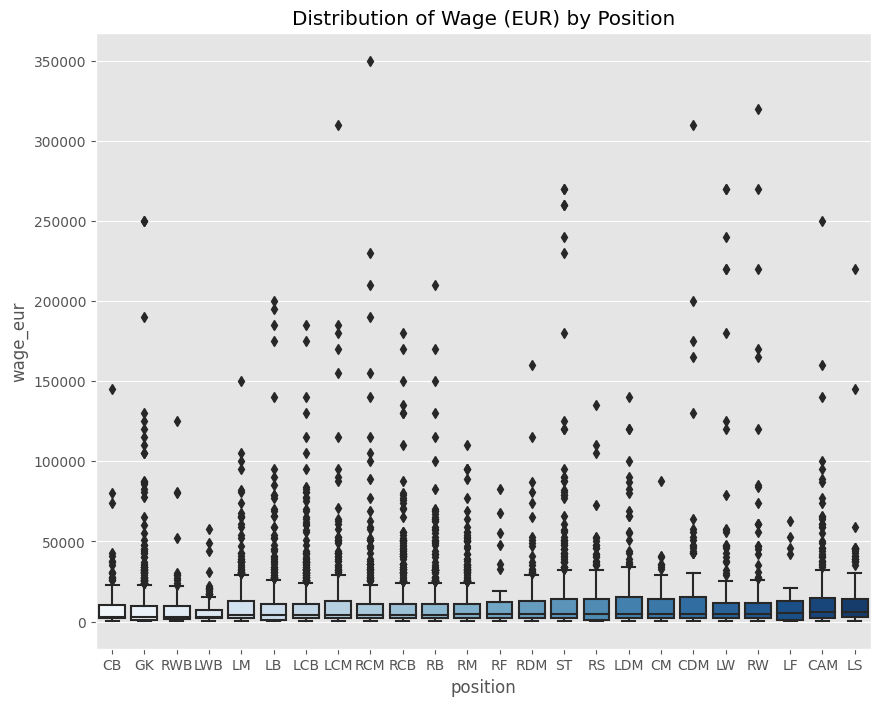

In [ ]:
# Calculate the median wage for each position
median_wage_eur = df_raw.groupby('position')['wage_eur'].median().sort_values(ascending=True)

## Create a boxplot to visualize the distribution of 'wage_eur' by 'position'
plt.figure(figsize=(10, 8))
sns.boxplot(x='position', y='wage_eur', data=df_raw, palette='Blues', order=median_wage_eur.index)
plt.title('Distribution of Wage (EUR) by Position')
plt.show()

It's difficult to compare wage_eur median values based on the chart above, as the values range is very big. Let's check the table of meadian wage_eur by position:

In [ ]:
df_raw.groupby('position')['wage_eur'].median().reset_index().sort_values(by='wage_eur', ascending=False)

,position,wage_eur
0,CAM,6000.0
11,LS,6000.0
9,LF,5500.0
21,RW,5000.0
20,RS,5000.0
19,RM,5000.0
18,RF,5000.0
17,RDM,5000.0
12,LW,5000.0
8,LDM,5000.0


There is a difference in the medium wage_eur across different positions.

Top 5 positions with the highest median wage:
- CAM: 6000.0 EUR
- LS: 6000.0 EUR
- LF: 5500.0 EUR
- RW: 5000.0 EUR
- RS: 5000.0 EUR

Positions with the lowest median wage of 3000.0 EUR: CB, LWB, GK, RWB

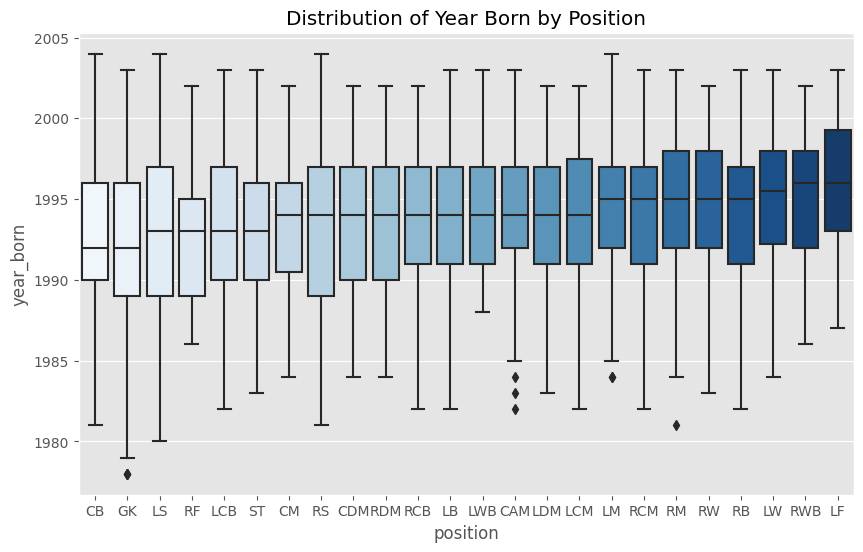

In [ ]:
# Create a boxplot of year_born by position
median_year = df_raw.groupby('position')['year_born'].median().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.boxplot(x='position', y='year_born', data=df_raw, palette='Blues', order=median_year.index)

plt.title('Distribution of Year Born by Position')
plt.show()

It is shown in the chart above that CB and GK are usually the youngest players, while LF, RWB, and LW are the oldest ones.

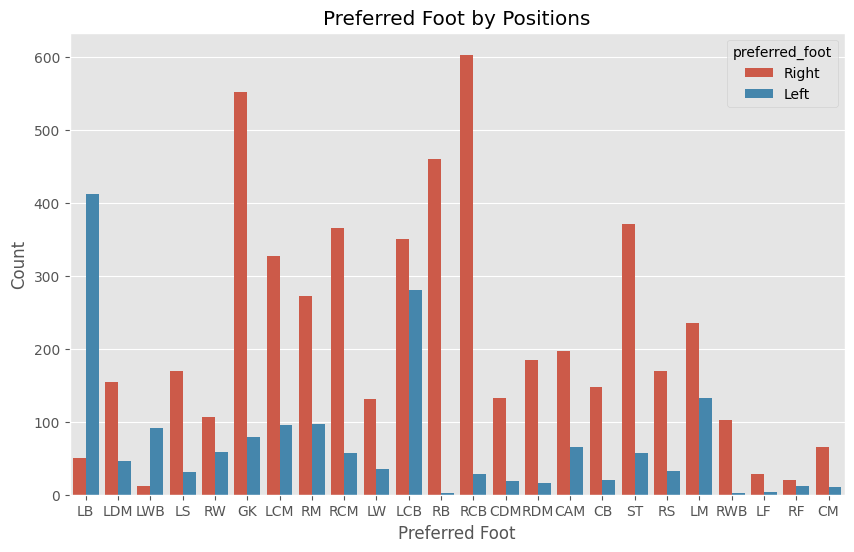

In [ ]:
# Create a count plot to visualize the distribution of preferred_foot across positions
plt.figure(figsize=(10, 6))
sns.countplot(x='position', hue='preferred_foot', data=df_raw)
plt.title('Preferred Foot by Positions')
plt.xlabel('Preferred Foot')
plt.ylabel('Count')
plt.show()

Only players at LB and LCB have high share of Left as a preferred foot. Taking this into account may help identify positions more precise.

Let's check if players of some nationalities are more common for some positions. The best way to check the relationships between two categorical variables is creating a heatmap:

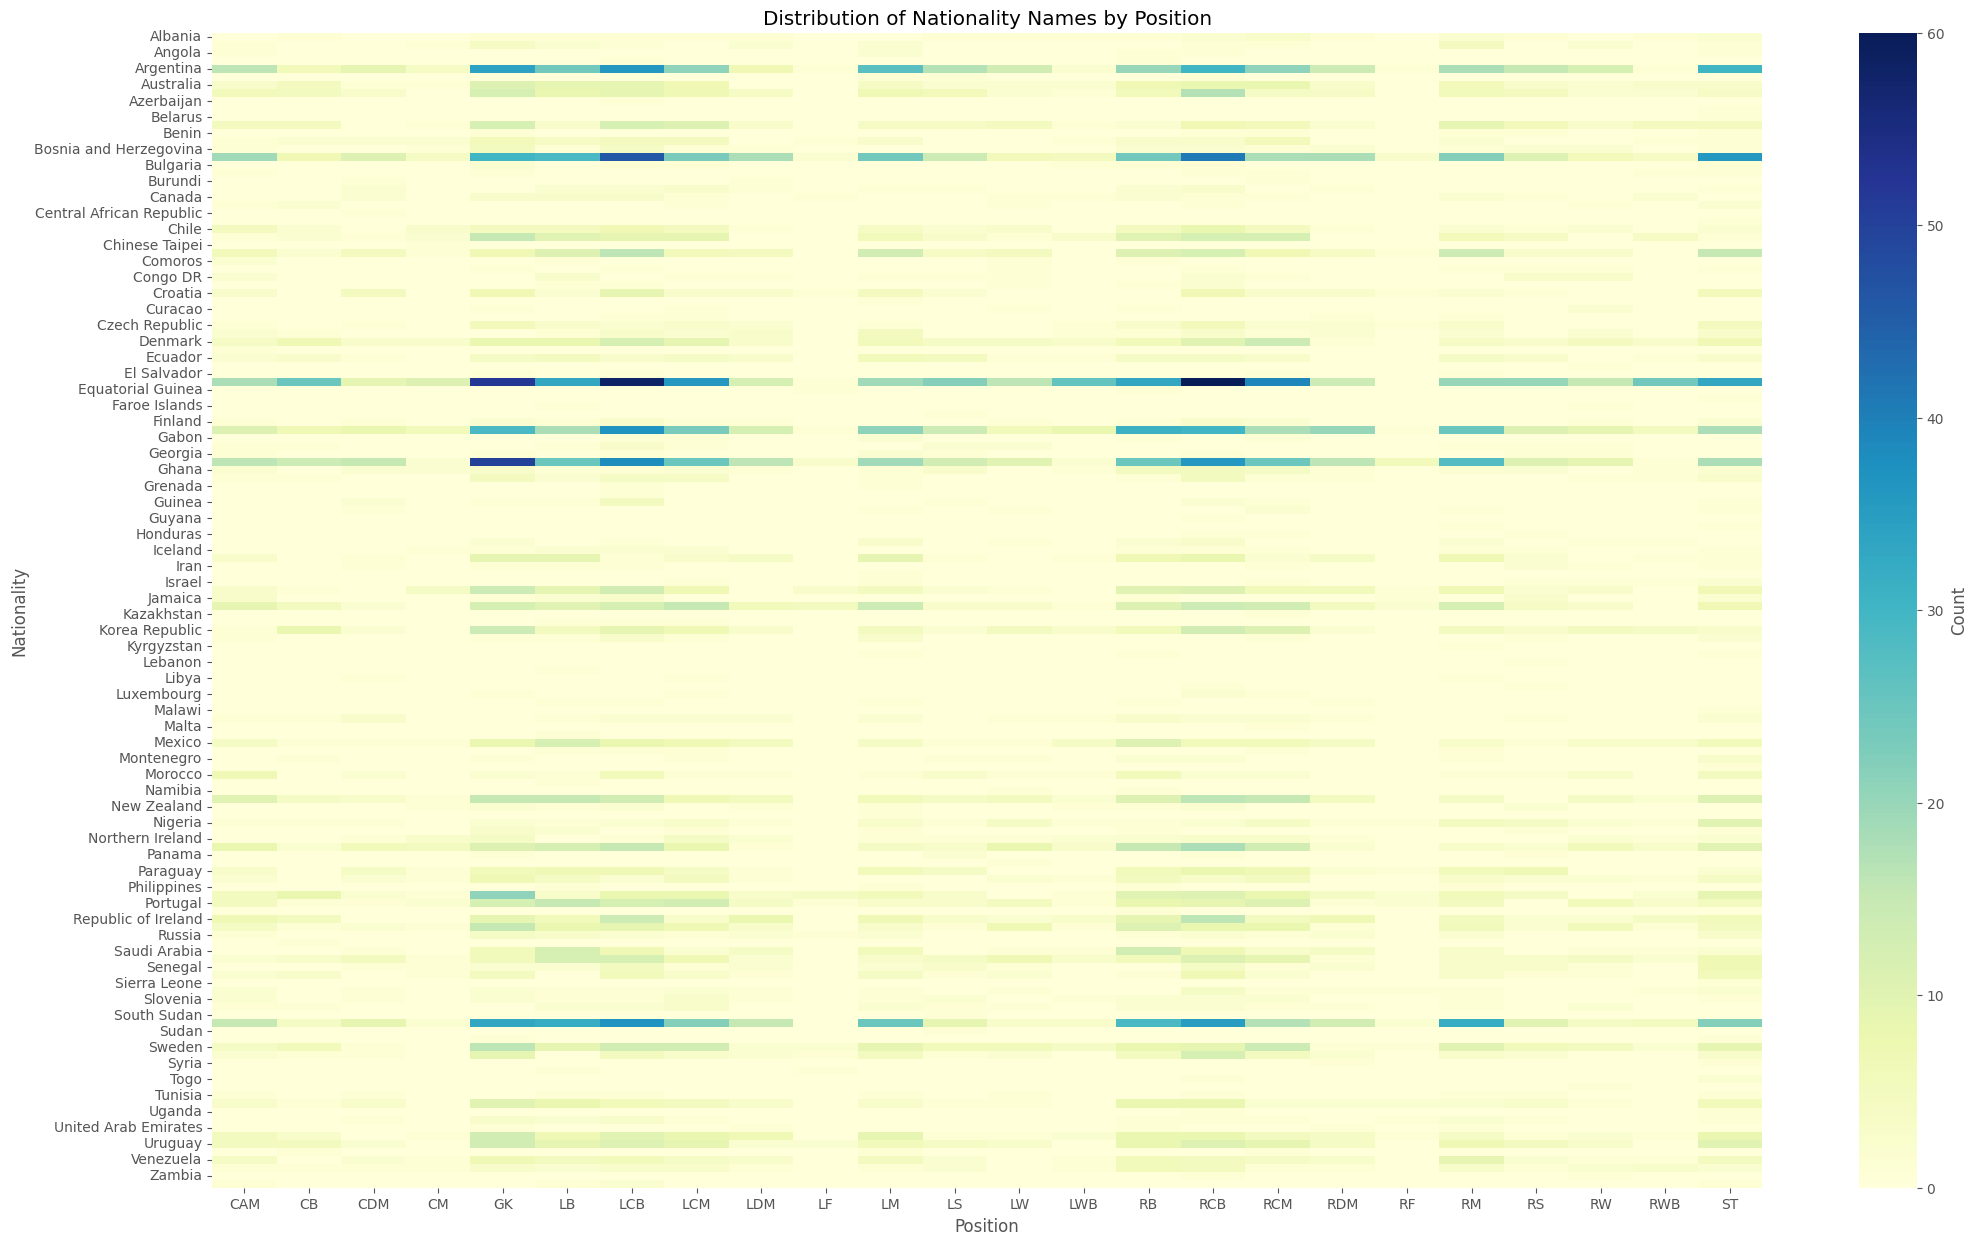

In [ ]:
# Create a crosstab to count the occurrences of each nationality by position
cross_tab = pd.crosstab(df_raw['nationality_name'], df_raw['position'])

# Plot a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(cross_tab, cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Distribution of Nationality Names by Position')
plt.xlabel('Position')
plt.ylabel('Nationality')
plt.show()

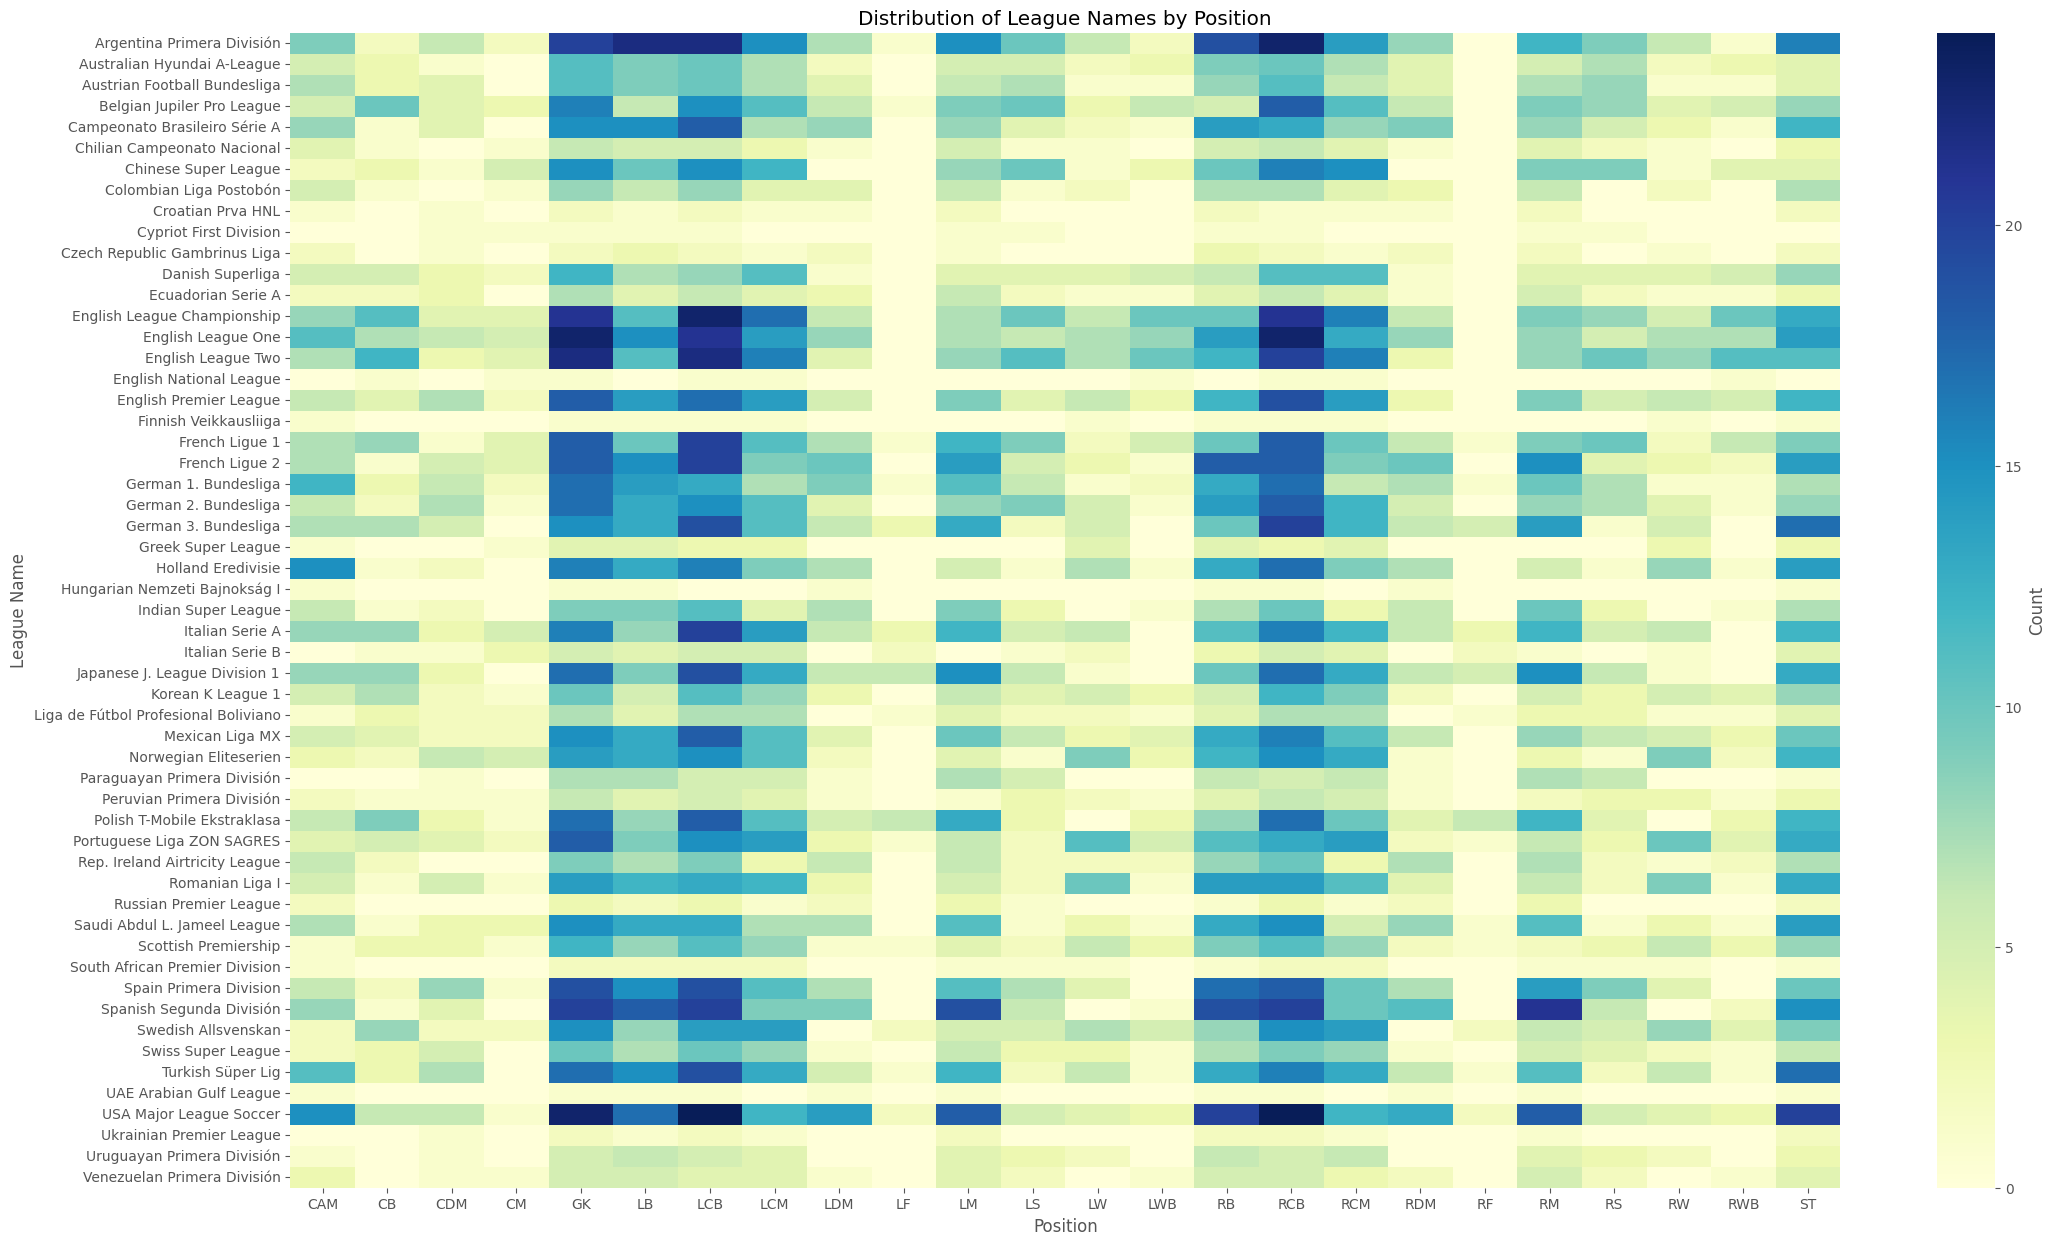

In [ ]:
# Create a crosstab to count the occurrences of each league_name by position
cross_tab = pd.crosstab(df_raw['league_name'], df_raw['position'])

# Plot a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(cross_tab, cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Distribution of League Names by Position')
plt.xlabel('Position')
plt.ylabel('League Name')
plt.show()

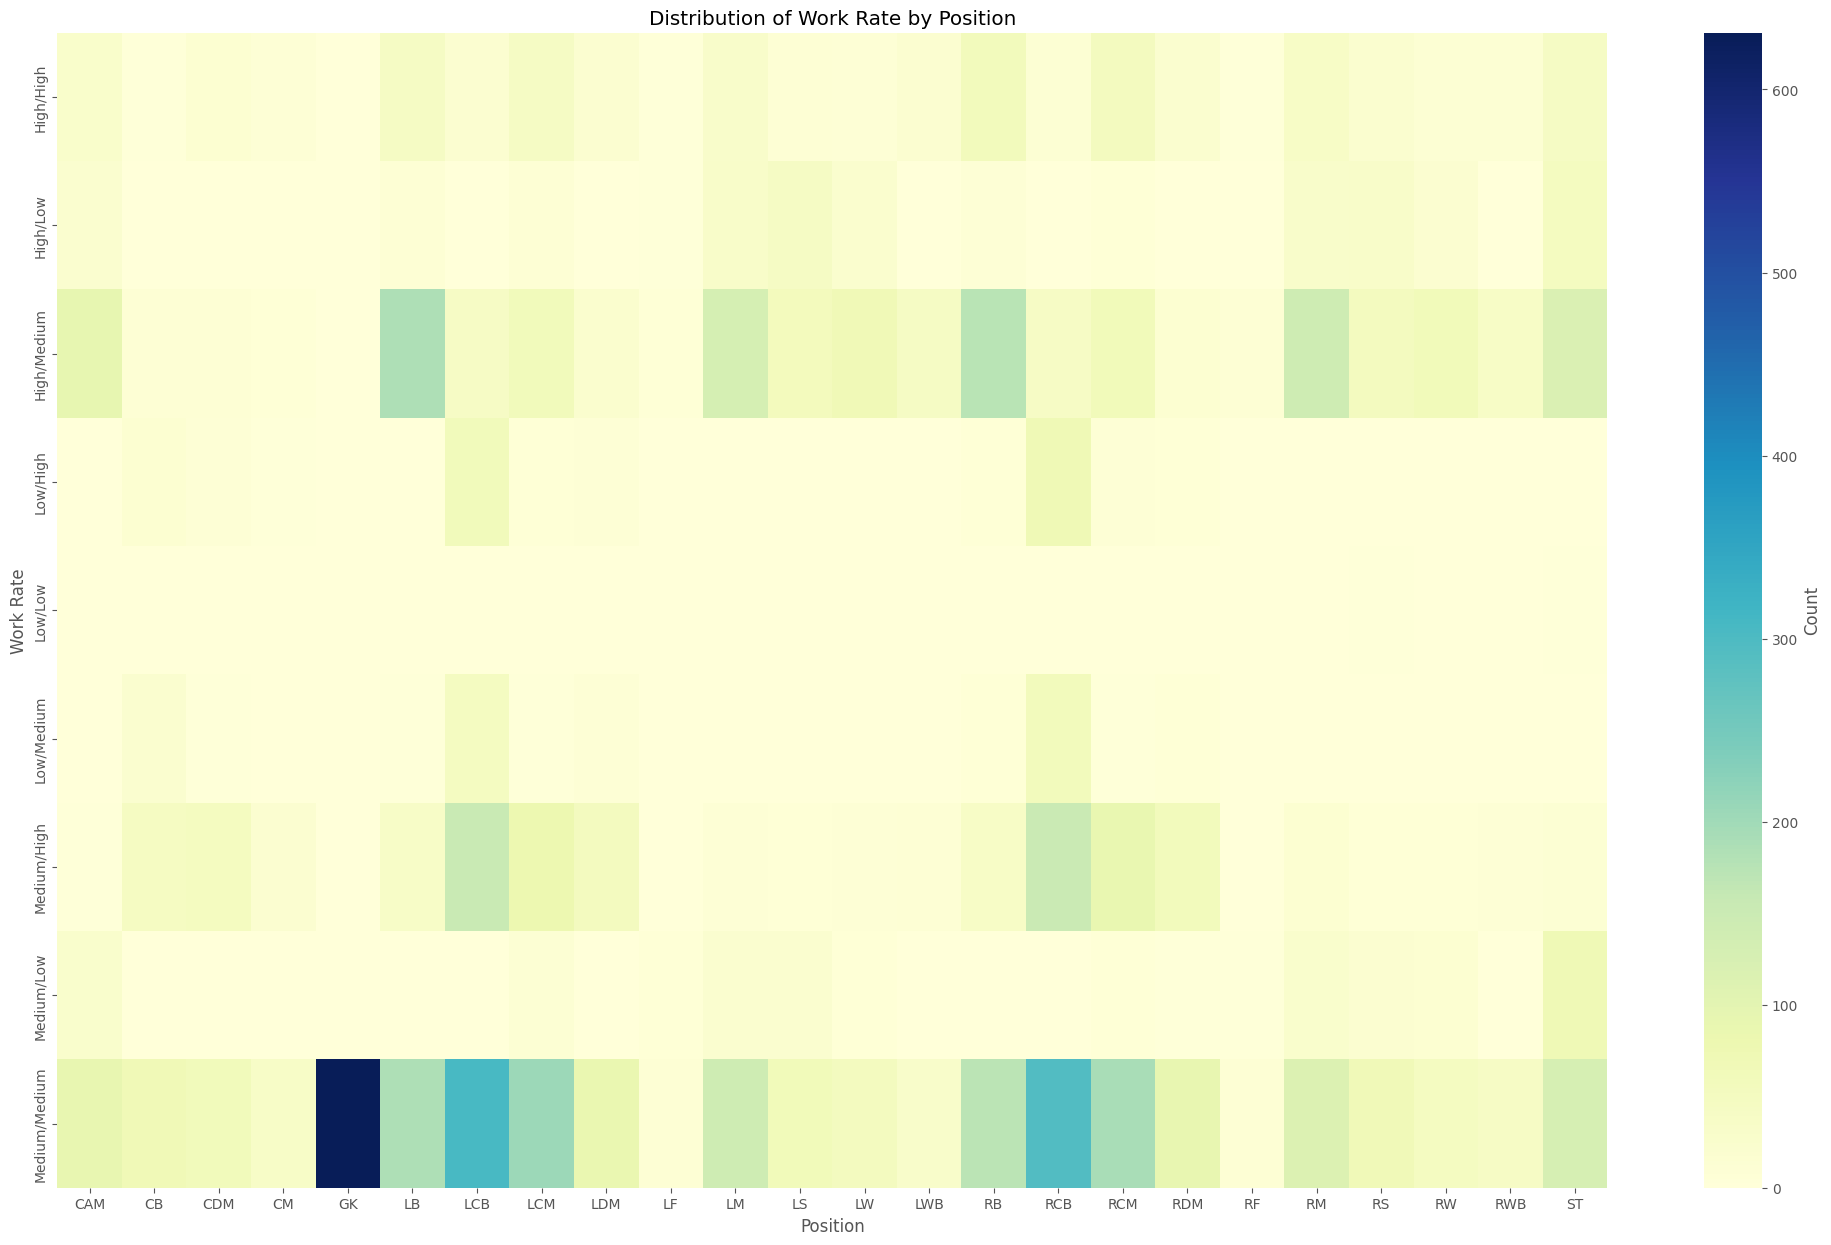

In [ ]:
# Create a crosstab to count the occurrences of each work_rate by position
cross_tab = pd.crosstab(df_raw['work_rate'], df_raw['position'])

# Plot a heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(cross_tab, cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Distribution of Work Rate by Position')
plt.xlabel('Position')
plt.ylabel('Work Rate')
plt.show()

## TODO: change heatmaps to show the percentage of all players of the same position

In [ ]:
# Add table for all numerical variables summary by position
grouped_data = df_raw[cols + ['position']].groupby(by='position').agg('mean').reset_index().T

print("Summary of numerical variables (mean) by positions:")
display(grouped_data)

Summary of numerical variables (mean) by positions:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
position,CAM,CB,CDM,CM,GK,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
overall,70.61597,67.616766,69.774834,69.48,69.545166,68.285097,68.36767,68.704492,69.477612,69.3125,68.712737,69.41791,69.240964,66.365385,68.388769,68.36767,68.489362,69.164179,70.09375,68.891599,68.58209,69.361446,66.423077,69.640187
potential,73.897338,70.05988,73.15894,72.173333,72.424723,71.419006,71.611727,72.049645,72.537313,74.0625,72.121951,72.482587,73.13253,69.740385,71.613391,71.51664,71.976359,72.452736,72.3125,72.319783,71.905473,73.090361,70.913462,72.081776
value_eur,6477794.676806,2475692.771084,5129039.735099,3654133.333333,3827694.136292,3795939.524838,3181830.427892,4357647.754137,5084626.865672,5335156.25,4827289.9729,4509075.0,7337289.156627,1936250.0,3746004.319654,3730641.838352,4296643.026005,4391940.298507,4775000.0,4316964.769648,4470995.024876,6327650.60241,2516826.923077,5964964.953271
release_clause_eur,11882505.976096,4660183.544304,9980034.246575,6699652.777778,7521306.020067,7174192.307692,6019996.621622,8391029.776675,9073373.056995,9051892.857143,8943424.068768,8428966.292135,14519561.290323,3444438.77551,6808842.696629,7156971.99341,8186650.990099,8041410.25641,8605096.774194,8097577.586207,8789084.210526,12181522.292994,4044154.639175,11147733.333333
wage_eur,14906.653992,8974.850299,16554.635762,10849.333333,10505.942948,11254.427646,10509.904913,12364.420804,13528.109453,11673.4375,11143.766938,12570.39801,18804.518072,6845.673077,11004.967603,10601.505547,12095.862884,11545.771144,14410.9375,10898.509485,11920.895522,17726.506024,9150.961538,16309.696262
weak_foot,3.365019,2.814371,3.046358,3.053333,2.562599,2.805616,2.812995,3.096927,3.099502,3.3125,3.208672,3.308458,3.295181,2.807692,2.978402,2.792393,3.111111,3.104478,3.28125,3.205962,3.154229,3.331325,3.028846,3.189252
international_reputation,1.258555,1.107784,1.18543,1.173333,1.191759,1.099352,1.136292,1.158392,1.164179,1.3125,1.132791,1.144279,1.204819,1.028846,1.107991,1.115689,1.115839,1.144279,1.21875,1.105691,1.149254,1.216867,1.048077,1.247664
height_cm,177.39924,186.491018,181.642384,178.493333,188.988906,178.008639,186.470681,178.579196,179.656716,175.59375,176.704607,182.850746,177.554217,179.009615,178.239741,186.362916,178.843972,180.38806,177.34375,176.406504,181.741294,177.012048,178.586538,183.988318
weight_kg,71.988593,80.0,75.125828,72.893333,82.740095,72.222462,80.03645,72.938534,73.268657,69.75,70.691057,77.0199,71.216867,71.884615,72.792657,79.843106,73.035461,74.114428,72.03125,71.176152,76.373134,71.283133,72.144231,78.745327


# 2. Data Preprocessing & Quality Assurance

Recommendations based on data exploration:
- drop columns with more than 80% of missing values
- Predict GK separately since GK variables (pace, shooting, passing, dribbling, defending, player_tags) only have values for GK
- Treat outliers in overall, potential, weight_kg, height_cm, wage_eur and value_eur
- Remove the body_type column as it's basically the combination of height_cm and weight_cm
- Transform birthday_date to year -> created the column "year_born"

Idea for imputation - it might make sence to do it for each position separately.


### Drop the columns with more than 80% of missing values

In [ ]:
# Drop columns club_loaned_from, nation_jersey_number, player_tags
df_raw = df_raw.drop(columns=['club_loaned_from', 'nation_jersey_number', 'player_tags'])

### Treat outliers with Winsorization

Winsorization is the transformation of values by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers, we use the 1st and 99th percentile to perform this transformation. 

* **height_cm, weight_kg**: have some outliers reflected in the box plots (in the EDA section)
* **overall, potential**: have some outliers reflected in the box plots (in the EDA section)
* **club_contract_valid_until**: most values are in the 2021-2024 range but the maximum value is 2031
* **wage_eur, value_eur, release_clause_eur**: these three have a very big range of values and are worse checking for outliers
* **pace**: look at 'describe table' with key metrics and found a very low minimum value of 28 as opposed to other values between Q1=62, Median = 70, Q3=77, Max = 97 


In [ ]:
outliers_features = ['height_cm', 'weight_kg', 'overall', 'potential', 'club_contract_valid_until', 'wage_eur', 'value_eur', 'release_clause_eur', 'pace']

def winsorize_col(df_raw, col):
    df_raw = df_raw.copy()
    # Calculate the 1st and 99th percentiles
    first_percentile = df_raw[col].quantile(0.01)
    ninety_ninth_percentile = df_raw[col].quantile(0.99)

    # Number of outliers having viewd the box plot. 
    count = len(df_raw[df_raw[col] < first_percentile]) + len(df_raw[df_raw[col] > ninety_ninth_percentile])
    print(f'outliers in {col}:', count)

    # Windsorize the 'num_rooms' column
    df_raw[col] = df_raw[col].apply(lambda x: first_percentile if x < first_percentile else (ninety_ninth_percentile if x > ninety_ninth_percentile else x))

    # Number of outliers remaining 
    count = len(df_raw[df_raw[col] < first_percentile]) + len(df_raw[df_raw[col] > ninety_ninth_percentile])
    print('outliers after winsorizing:', count)

    return df_raw

for feature in outliers_features: 
    df_raw = winsorize_col(df_raw, feature)
    print()

outliers in height_cm: 128
outliers after winsorizing: 0

outliers in weight_kg: 101
outliers after winsorizing: 0

outliers in overall: 130
outliers after winsorizing: 0

outliers in potential: 152
outliers after winsorizing: 0

outliers in club_contract_valid_until: 10
outliers after winsorizing: 0

outliers in wage_eur: 77
outliers after winsorizing: 0

outliers in value_eur: 145
outliers after winsorizing: 0

outliers in release_clause_eur: 142
outliers after winsorizing: 0

outliers in pace: 113
outliers after winsorizing: 0



### Predict GK 'Manually' 

Since we see that the NAs in the goalkeeping speed column are not missing at random but rather only missing for field players (Non-GK), we can make accurate predictions for GKs based on that. We then remove the rows with GK from our data by just keeping those where goalkeeping speed has NAs.

In [ ]:
goalkeeper_pred = df_raw[6895:].apply(lambda x: pd.Series({'id': x['id'], 'position': 'GK' if x['goalkeeping_speed'] > 0 else x['position']}), axis=1).dropna()
goalkeeper_pred['id'] = goalkeeper_pred['id'].astype(int)

# remove rows with GK 
df_raw = df_raw[pd.isna(df_raw['goalkeeping_speed'])]

### Impute missing values using KNN

To determine the best value of n_neighbors, we ran the model by setting k at 2, 3, 4 to determine the optimal k based on f1 score of the random forest classifier; as there is no difference we opted for the smallest (2). There are only 5 missing values, could be more time efficient to simply drop them or impute the mean, however, we have opted for a KNN imputation to scale the project if we were to add more columns with more missing values. 

* k=2, f1=0.40063846767757383
* k=3, f1=0.40063846767757383
* k=4, f1=0.40063846767757383

In [ ]:
df_raw[df_raw['value_eur'].isnull()]

,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,league_name,league_level,club_jersey_number,club_joined,club_contract_valid_until,...,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position,year_born,body_type_grouped
4001,124344,İ. Öztürk,67.0,67.0,NaN,3000.0,1981-06-21,186.0,80.0,Altay SK,Turkish Süper Lig,1,38,2017-08-24,2022.0,...,44,51,51,70,68,62,15,13,10,10,6,NaN,CB,1981,Normal
5599,152912,J. Sand,75.0,75.0,NaN,13000.0,1980-07-17,182.0,79.0,Club Atlético Lanús,Argentina Primera División,1,9,2019-01-21,2022.0,...,69,85,85,45,21,25,11,16,15,9,14,NaN,LS,1980,Normal
6905,115909,Rubén Castro,69.0,69.0,NaN,3000.0,1981-06-27,169.0,68.0,FC Cartagena,Spanish Segunda División,2,7,2020-09-12,2022.0,...,74,75,68,36,12,14,14,8,15,8,12,NaN,NaN,1981,Normal
7042,158293,Zheng Zhi,67.0,67.0,NaN,5000.0,1980-08-20,180.0,75.0,Guangzhou FC,Chinese Super League,1,10,2010-07-01,2021.0,...,72,68,72,69,64,62,13,16,6,10,14,NaN,NaN,1980,Normal
7528,140222,P. Da Silva,67.0,67.0,NaN,500.0,1980-02-01,180.0,76.0,12 de Octubre FC,Paraguayan Primera División,1,3,2021-01-13,2021.0,...,36,43,70,70,67,64,9,8,15,16,9,NaN,NaN,1980,Stocky


In [ ]:
knn_imputer = KNNImputer(n_neighbors=2)
df_raw[['value_eur']] = knn_imputer.fit_transform(df_raw[['value_eur']])

In [ ]:
# # separate training and testing dataset
# positions = ['LB', 'LDM', 'LWB', 'LS', 'RW', 'LCM', 'RM', 'RCM', 'LW', 'LCB',
#              'RB', 'RCB', 'CDM', 'RDM', 'CAM', 'CB', 'ST', 'RS', 'LM', 'RWB',
#              'LF', 'RF', 'CM']

# df2 = df_raw.copy()

# for i in positions: # list(df_raw['position'].unique()):
#     imputed_data = knn_imputer.fit_transform(df2[df2['position'] == i][columns_to_impute])
#     df2[df2['position'] == i][columns_to_impute] = imputed_data

We also exclude all columns from our features that are exclusively related to Goalkeepers: 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed'.

In [ ]:
features = ['overall', 'potential', 'value_eur', 'wage_eur','height_cm', 'weight_kg', 'club_jersey_number', 'preferred_foot',
            'weak_foot', 'skill_moves', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'work_rate',
            'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
            'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 
            'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
            'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle','position', 'year_born']

In [ ]:
df = df_raw[features]

### Encoding Categorical Variables: 

| Variable      | Encoding          | Notes|
| --------      | -------           | ------- | 
| weak foot     | One Hot Encoding  | 1-5 stars |
| skill moves   | One Hot Encoding  | 2-5 stars |
| work rate     | Binary Binning    | Binary columns for defense and attackers (high/low) |
| preferred foot| Label Encoding    |   |
| position      | Label Encoding    |   |

In [ ]:
def one_hot_encoding(data, column):
    data = data.copy() # create deep copy of data

    dummy = pd.get_dummies(data[column]).astype(int) # get dummies
    data = pd.concat([data, dummy], axis=1) # add dummy columns to dataframe 
    data = data.drop(columns = column)

    return data

In [ ]:
df = one_hot_encoding(df, 'weak_foot')
df = df.rename(columns={1:'wf_one_star', 2:'wf_two_stars', 3:'wf_three_stars', 4:'wf_four_stars', 5:'wf_five_stars'})

df = one_hot_encoding(df, 'skill_moves')
df = df.rename(columns={2:'sm_two_stars', 3:'sm_three_stars', 4:'sm_four_stars', 5:'sm_five_stars'})

In [ ]:
# separate two words from work rate (defense in first position and attack in second position)
# only keep high and low (ignore medium as our dummy variable) 

df['wr_high_def'] = df['work_rate'].str.contains('High/').astype(int)
df['wr_low_def'] = df['work_rate'].str.contains('Low/').astype(int)

df['wr_high_atk'] = df['work_rate'].str.contains('/High').astype(int)
df['wr_low_atk'] = df['work_rate'].str.contains('/Low').astype(int)

In [ ]:
# Apply label encoding
encoder = LabelEncoder()
df['preferred_foot'] = encoder.fit_transform(df['preferred_foot'])
#df['position'] = encoder.fit_transform(df['position'])

In [ ]:
# separate training and testing dataset
tr = df[:6264]
te = df[6264:]

# 3. Model Selection

First we split our training data intro sub training and validation set (based on 80/20 split) and test out models. Once we have pre-selected a best model (based on f1, precision, recall), we run a hyperparameter tuning algorithm to determine the best set of hyperparameter for this model. The hyperparameter tuning algorithm is run using cross validation (based on f1 score). Finally, we run the model with the tuned hyphyperparameterer on the whole training dataset and make predictions to submit to Kaggle (exported as csv file).

### Random Forest Classifier

**Rationale**: We chose to start with a Random Forest Classifier as one of its main advantages is handling non-linearity as it can capture complex relationships between features and target variables without assuming linear patterns. It can also rank features by their importance in decision-making, aiding in feature selection which is a significant advantage when developing a model. However, the downside is that it is prone to overfitting and has a bias towards the dominant classes (and our current dataset has imbalanced classes). 

In [ ]:
features = ['overall', 'potential', 'value_eur', 'wage_eur','height_cm', 'weight_kg', 'club_jersey_number', 'preferred_foot',
            'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
            'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
            'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 
            'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
            'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle','position', 'wf_one_star', 'wf_two_stars', 
            'wf_three_stars', 'wf_four_stars', 'wf_five_stars', 'sm_two_stars', 'sm_three_stars', 'sm_four_stars', 'sm_five_stars', 'year_born']

In [ ]:
# get final X train, y train and X test dataframes
X_train = tr[features].drop('position', axis=1)
y_train = tr['position']

X_test = te[features].drop('position', axis=1)

x_subtrain, x_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [ ]:
best_model = RandomForestClassifier(random_state=42).fit(x_subtrain, y_subtrain) 
y_pred = best_model.predict(x_val)

cr = classification_report(y_val, y_pred, digits=4)
f1 = f1_score(y_val, y_pred, average='micro')

print('F1-score: ', f1)
print(cr)

F1-score:  0.40063846767757383
              precision    recall  f1-score   support

         CAM     0.2222    0.2381    0.2299        42
          CB     0.0000    0.0000    0.0000        45
         CDM     0.1818    0.0588    0.0889        34
          CM     0.0000    0.0000    0.0000        13
          LB     0.6532    0.8351    0.7330        97
         LCB     0.4957    0.4597    0.4770       124
         LCM     0.2762    0.3118    0.2929        93
         LDM     0.4545    0.1136    0.1818        44
          LF     0.0000    0.0000    0.0000         6
          LM     0.2000    0.2615    0.2267        65
          LS     0.1818    0.0476    0.0755        42
          LW     0.0000    0.0000    0.0000        28
         LWB     0.0000    0.0000    0.0000        16
          RB     0.5691    0.7955    0.6635        88
         RCB     0.4510    0.7667    0.5679       120
         RCM     0.2460    0.3407    0.2857        91
         RDM     0.2083    0.1111    0.1449       

### Gradient Boosting Classifier

**Rationale**: We also tested a Gradient Boosting Classifier which may improve model accuracy by focusing on hard-to-classify instances. In boosting, the training data is re-weighted at each iteration, with more weight given to the samples that were misclassified by the previous models. The benefit of this model is that it can handle complex relationships (and handle non-linearity) and generalizes better to new unseen data. 

In [ ]:
best_model = GradientBoostingClassifier(random_state=42).fit(x_subtrain, y_subtrain)
y_pred = best_model.predict(x_val)

cr = classification_report(y_val, y_pred, digits=4)
f1 = f1_score(y_val, y_pred, average='micro')

print('F1-score: ', f1)
print(cr)

KeyboardInterrupt: 

### Ensemble Modelling using Stacking Regressor

**Rationale**: using Random Forest for same reasons as stated above with a logistic Regression as a final estimator given it's simplicity. A simpler model is less computationally demanding, and the goal was mostly to develop an alternative modeling technique. We decided not to opt for Random Forest & Gradient Boosting as it lengthened the run time of our code with limited benefits.

In [ ]:
estimators = [('rf', RandomForestClassifier(random_state=42))]
reg = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

best_model = reg.fit(x_subtrain, y_subtrain)
y_pred = best_model.predict(x_val)

cr = classification_report(y_val, y_pred, digits=4)
f1 = f1_score(y_val, y_pred, average='micro')

print('F1-score: ', f1)
print(cr)

F1-score:  0.39584996009577017
              precision    recall  f1-score   support

         CAM     0.2750    0.2619    0.2683        42
          CB     0.0000    0.0000    0.0000        45
         CDM     0.0000    0.0000    0.0000        34
          CM     0.0000    0.0000    0.0000        13
          LB     0.6783    0.8041    0.7358        97
         LCB     0.5096    0.4274    0.4649       124
         LCM     0.2397    0.3763    0.2929        93
         LDM     0.0000    0.0000    0.0000        44
          LF     0.0000    0.0000    0.0000         6
          LM     0.1852    0.3077    0.2312        65
          LS     0.0000    0.0000    0.0000        42
          LW     0.0000    0.0000    0.0000        28
         LWB     0.0000    0.0000    0.0000        16
          RB     0.5806    0.8182    0.6792        88
         RCB     0.4498    0.7833    0.5714       120
         RCM     0.1748    0.2747    0.2137        91
         RDM     0.0000    0.0000    0.0000       

# 4. Hyperparameter Tuning (Random Forest Classifier)



In [ ]:
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=2)

# Define the hyperparameter grid to search
param_dist = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'random_state': [42]
}

random_search = GridSearchCV(rf, param_dist, cv = 2, scoring='f1_micro', verbose=1, n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)
print("Best F1 Micro Score: ", random_search.best_score_)

rf_best_params = random_search.best_params_

Fitting 2 folds for each of 144 candidates, totalling 288 fits


Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
Best F1 Micro Score:  0.3975095785440613


# 5. Run Final Model

In [ ]:
rf_best_model = RandomForestClassifier(**rf_best_params).fit(X_train, y_train)

### Predictions for Kaggle Competition 

In [ ]:
# predict positions for the test set and decode to position names
rf_preds = rf_best_model.predict(X_test)
#decoded_rf_preds = encoder.inverse_transform(rf_preds)

In [ ]:
# Merge with goalkeeper predictions
rf_preds = pd.DataFrame({"id": df_raw[6264:]["id"], "position": rf_preds})
rf_merged_df = pd.merge(goalkeeper_pred, rf_preds, how='outer', on='id')

# Sort the merged DataFrame based on the order in test_raw
rf_result = pd.merge(test_raw['id'], rf_merged_df, how='left', on='id')
rf_result['position'] = rf_result['position_x'].fillna(rf_result['position_y'])

In [ ]:
print('number of times each position was predicted:')

rf_result['position'].value_counts()

number of times each position was predicted:


position
RCB    113
ST      93
RB      87
LB      81
GK      70
RCM     67
LCB     65
LCM     57
LM      54
RM      45
CAM     27
LS       3
RDM      3
RW       1
RS       1
Name: count, dtype: int64

In [ ]:
#Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"id": test_raw["id"], "position": rf_result['position']})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)

# 6. Conclusion

When looking at the list of feature importance one must consider that we are predicting many different classes as such, feature importance may also be linked to features important to predict dominant classes as this may lead to higher model performance. The preferred foot being at the top of the list intuitively makes sense given that the model is trying to classify players very specifically and for many positions determine if the player plays on the 'Left' or 'Right' which may be correlated to the preferred foot.

In [ ]:
feature_importances = rf_best_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

display(feature_importance_df.head(20))

,Feature,Importance
7,preferred_foot,0.090707
36,mentality_positioning,0.054502
16,attacking_heading_accuracy,0.053585
14,attacking_crossing,0.045471
42,defending_sliding_tackle,0.045165
41,defending_standing_tackle,0.043315
12,defending,0.034815
35,mentality_interceptions,0.034761
37,mentality_vision,0.033553
15,attacking_finishing,0.033260
